<a href="https://colab.research.google.com/github/soerenhm/magnetic-field-lattices/blob/main/magnetic_field_lattice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from numpy import sqrt, conj

def rot(θ, ϕ):
  """
  Composite `θ`-rotation about `y` followed by a `ϕ`-rotation about `z`.
  
  Any unit vector in spherical coordinates can be represented as `rot(θ,ϕ) * ẑ`. 
  """
  cosθ, sinθ = np.cos(θ), np.sin(θ)
  cosϕ, sinϕ = np.cos(ϕ), np.sin(ϕ)
  Ry = np.array([[ cosθ, 0, sinθ],
                 [  0,   1,  0 ],
                 [-sinθ, 0, cosθ]])
  Rz = np.array([[cosϕ, -sinϕ, 0],
                 [sinϕ,  cosϕ, 0],
                 [ 0,     0,   1]])
  return np.matmul(Rz, Ry)

def rot_deg(θ, ϕ):
  """Like `rot` but with angles in degrees instead of radians."""
  return rot(np.deg2rad(θ), np.deg2rad(ϕ))

In [3]:
from dataclasses import dataclass

@dataclass
class JonesVector:
  x: complex
  y: complex

  def __post_init__(self):
    if self.x == 0 and self.y == 0:
      raise ValueError("JonesVector cannot be a zero vector!")

  def asvector(self):
    x, y = self.x, self.y
    r = sqrt(x*np.conj(x) + y*conj(y))
    return np.array([x/r, y/r, 0+0j])


@dataclass 
class Direction:
  θ: float
  ϕ: float

  def __post_init__(self):
    self.θ = self.θ % 180
    self.ϕ = self.ϕ % 360

  def asvector(self):
    θ, ϕ = map(np.deg2rad, [self.θ, self.ϕ])
    return np.array([np.sin(θ)*np.cos(ϕ), np.sin(θ)*np.sin(ϕ), np.cos(θ)])
    # return np.dot(self.rotation(), np.array([0,0,1]))

  def rotation(self):
    return rot_deg(self.θ, self.ϕ)


@dataclass
class PlaneWave:
  λ: float
  dir: Direction
  pol: JonesVector

  def __post_init__(self):
    if self.λ <= 0:
      raise ValueError("Wavelenght must be strictly positive!")

  def wavenumber(self):
    return 2*np.pi/self.λ

  def wavevector(self):
    return self.dir.asvector() * self.wavenumber()

  def polarization(self):
    return np.dot(self.dir.rotation(), self.pol.asvector())

In [4]:
import numba

@numba.njit
def _sample_planewave(x, y, z, k, e):
  E = np.zeros((len(x), len(y), 3), dtype=np.complex128)
  for i, xi in enumerate(x):
    for j, yj in enumerate(y):
      eikr = np.exp(1j*(k[0]*xi + k[1]*yj + k[2]*z))
      E[i,j,0] = e[0]*eikr
      E[i,j,1] = e[1]*eikr
      E[i,j,2] = e[2]*eikr
  return E

def sample_planewave(pw: PlaneWave, x: list, y: list, z: float = 0.0):
  """Samples a plane wave in the `z` plane over coordinates `(x,y)`."""
  k = pw.wavevector()
  e = pw.polarization()
  return _sample_planewave(x, y, z, k, e)

In [5]:
from ipywidgets import interact
import ipywidgets as widgets

# GUI elements

def slider_θ(descr, val):
  return widgets.FloatSlider(
      value=val,
      min=-90,
      max=90,
      step=0.5,
      description=descr,
      readout=True
  )

def slider_ϕ(descr, val):
  return widgets.FloatSlider(
      value=val,
      min=-180,
      max=180,
      step=0.5,
      description=descr,
      readout=True
  )

def text_wavelen(descr, val):
  return widgets.BoundedFloatText(
      value=val,
      min=0,
      step=10,
      max=10_000,
      description=descr,
      disabled=False
  )

def text_res(val):
  return widgets.BoundedIntText(
      value=val,
      min=2,
      max=1000,
      step=1,
      description="Resolution:",
  )

def text_bounds(val):
  return widgets.BoundedFloatText(
      value=val,
      min=1,
      max=100,
      step=1,
      description="Bounds (λ):"
  )

def text_jonesvec(val):
  return widgets.Text(
      value=val,
      description="Polarization: ",
  )

In [7]:
import matplotlib.pyplot as plt

# UI elements

wλ = text_wavelen("Fundamental:", 1480)
wθ = slider_θ("θ (deg):", val=10)
wψ = slider_θ("ψ (deg):", val=5)
we_fun = text_jonesvec("[1.42,-1j+1]")
we_shg1= text_jonesvec("[1,1j]")
we_shg2= text_jonesvec("[1,-1j]")
wres = text_res(200)
wbound = text_bounds(5)

ui = widgets.VBox([
  widgets.HBox([wλ, wres, wbound]),
  widgets.HBox([wψ, we_fun]),
  widgets.HBox([wθ, we_shg1, we_shg2]),
])

# Parse and plot user inputs

downsample = 5  # downsample vecotr fields (otherwise can't see arrows)

def plot_current_density(pw_fun, pw_sh1, pw_sh2, x, y):
  E_fun = sample_planewave(pw_fun, x, y)
  E_sh1 = sample_planewave(pw_sh1, x, y)
  E_sh2 = sample_planewave(pw_sh2, x, y)
  E_sh = E_sh1 + E_sh2
  J = np.real(E_fun * E_fun * conj(E_sh))

  k = downsample
  X, Y = np.meshgrid(x/pw_fun.λ, y/pw_fun.λ, indexing="ij")

  plt.figure(dpi=150)
  plt.quiver(X[::k,::k], Y[::k,::k], J[::k,::k,0], J[::k,::k,1], headlength=3, headwidth=2, lw=0.5)
  plt.xlabel("x / λ")
  plt.ylabel("y / λ")
  plt.title(r"$\vec J \propto \vec E(\omega) \vec E(\omega) \vec E(-2\omega)$")

def parse_inputs(λ, ψ, θ, e_fun, e_sh1, e_sh2, res, bounds):
  pw_fun = PlaneWave(λ*1e-9, Direction(ψ, 90), JonesVector(*eval(e_fun)))
  pw_sh1 = PlaneWave(λ/2*1e-9, Direction(θ/2, 0), JonesVector(*eval(e_sh1)))
  pw_sh2 = PlaneWave(λ/2*1e-9, Direction(θ/2, 180), JonesVector(*eval(e_sh2)))
  x = y = np.linspace(-bounds*λ*1e-9, bounds*λ*1e-9, res)

  plot_current_density(pw_fun, pw_sh1, pw_sh2, x, y)
  return pw_fun, pw_sh1, pw_sh2, x, y

out = widgets.interactive_output(parse_inputs, {"λ": wλ, "ψ": wψ, "θ": wθ, "e_fun": we_fun, "e_sh1": we_shg1, "e_sh2": we_shg2, "res": wres, "bounds": wbound})
display(ui, out)

Output()

Text(0.5, 1.0, '$\\vec J$')

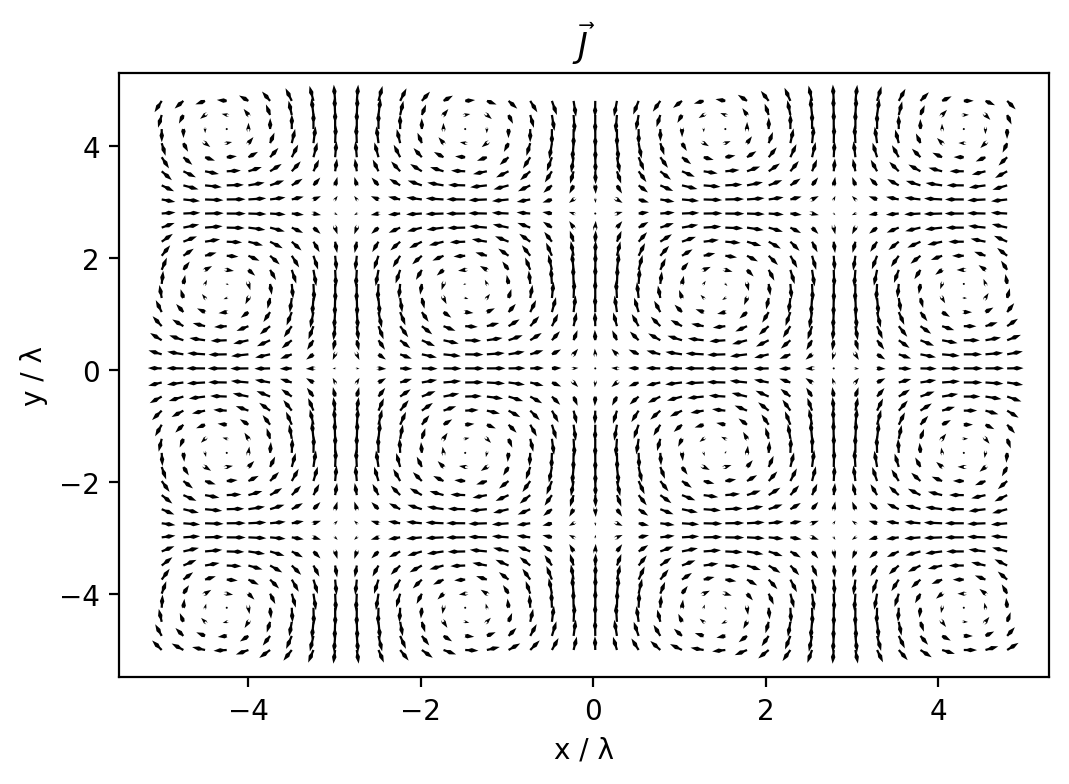

In [9]:
## Excitation config
λ = 1480e-9       # wavelength of fundamental in nm
θ = 10            # angle in deg between SH beams in deg
ψ = 5             # angle in deg between fundamental and Z
e_fun = [1, np.sqrt(-1j)]
e_sh1 = [1, 1j]
e_sh2 = [1, -1j]

## Plots config
xlim = [-5*λ, 5*λ]
ylim = [-5*λ, 5*λ]
res = 200
k = downsample = 5


## Calculations + plotting

pw_fun = PlaneWave(λ, Direction(ψ, 90), JonesVector(*e_fun))
pw_sh1 = PlaneWave(λ/2, Direction(θ/2, 0), JonesVector(*e_sh1))
pw_sh2 = PlaneWave(λ/2, Direction(θ/2, 180), JonesVector(*e_sh2))

x = np.linspace(*xlim, res)
y = np.linspace(*ylim, res)

E_fun = sample_planewave(pw_fun, x, y)
E_sh1 = sample_planewave(pw_sh1, x, y)
E_sh2 = sample_planewave(pw_sh2, x, y)

E_sh  = E_sh1 + E_sh2
J = np.real( E_fun*E_fun*np.conj(E_sh) )

X, Y = np.meshgrid(x, y, indexing="ij")
plt.figure(dpi=200)
plt.quiver(X[::k,::k]/λ, Y[::k,::k]/λ, J[::k,::k,0], J[::k,::k,1], headlength=3, headwidth=2, lw=0.5)
plt.xlabel("x / λ")
plt.ylabel("y / λ")
plt.title(r"$\vec J$")

In [ ]:
sqrt(2)